## Forward-backward splitting for time-varying graphical lasso
This notebook shows how to minimise the time-varying graphical lasso with element-wise penalty norms across time-points.

First of all, as always, let's create a bunch of data.
For this task, we generate eah variable to change according to a certain behaviour which can be described as evolution via tigonometric functions, such as `sin` and `cos`.

In [279]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import squareform
from regain.datasets import is_pos_def
reload(datasets);

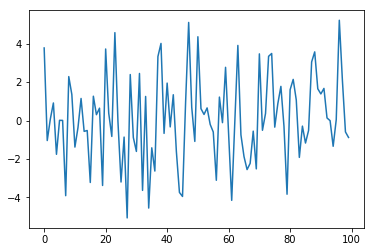

In [275]:
np.random.seed(7)

fs = 10e3
N = 100
amp = 2*np.sqrt(2)
freq = 1.0
noise_power = 0.001 * fs / 2
time = np.arange(N) / fs
z = amp*np.sin(2*np.pi*freq*time)
z += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
plt.plot(z);

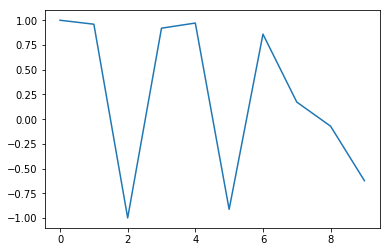

In [276]:
from scipy import signal
sig = signal.sweep_poly(np.arange(10), np.arange(20))
plt.plot(sig);

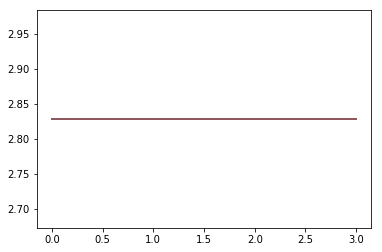

In [277]:
T = 4

x = np.tile(np.linspace(0, T-1, T), (n_interactions, 1))
zz = amp * signal.square(2 * np.pi * freq * x + phase, duty=.5)
plt.plot(x.T, zz.T);

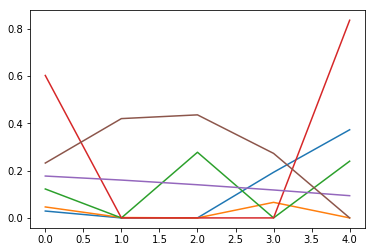

In [278]:
np.random.seed(7)
n_samples = 10
n_dim_obs = 4
n_dim_lat = 0  # we want to use the TGL, without latent variables
T = 5

upper_idx = np.triu_indices(n_dim_obs, 1)
n_interactions = len(upper_idx[0])

x = np.tile(np.linspace(0, T-1, T), (n_interactions, 1))
phase = np.random.rand(n_interactions, 1)
freq = np.random.rand(n_interactions, 1) - .70
A = np.random.rand(n_interactions, 1)
y = A * np.sin(2. * np.pi * freq * x + phase)

# threshold
y = np.maximum(y, 0)

plt.plot(x.T, y.T);

In [9]:
Y = np.array([squareform(y[:, j]) + np.eye(n_dim_obs) for j in range(y.shape[1])])
assert all(is_pos_def(_) for _ in Y)

In [280]:
from sklearn.gaussian_process import kernels
ker = np.array([kernels.RBF(length_scale=.2)(y[:, j][:, None]) for j in range(y.shape[1])])

In [281]:
from regain import datasets; reload(datasets);

n_samples = 10
n_dim_obs = 4
n_dim_lat = 0  # we want to use the TGL, without latent variables
T = 3

data = datasets.make_dataset(
     mode='sin', n_samples=n_samples, n_dim_lat=n_dim_lat, n_dim_obs=n_dim_obs, T=T)

AssertionError: 

Generate the data starting from the inverse covariance matrices.

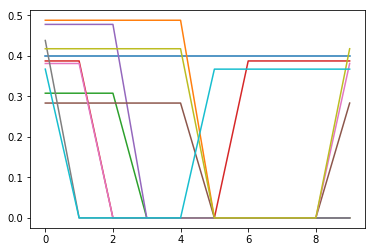

In [283]:
np.random.seed(7)

n_samples = 100
n_dim_obs = 5
T = 10

def make_sin(n_dim_obs, n_dim_lat, T, shape='smooth', closeness=1):
    upper_idx = np.triu_indices(n_dim_obs, 1)
    n_interactions = len(upper_idx[0])
    x = np.tile(np.linspace(0, (T-1.) / closeness, T), (n_interactions, 1))
    phase = np.random.rand(n_interactions, 1)
    freq = np.random.rand(n_interactions, 1) - .50
    A = (np.random.rand(n_interactions, 1) + 1) / 2.
    
    if shape == 'smooth':
        y = A * np.sin(2. * np.pi * freq * x + phase)
    else:
        y = A * signal.square(2 * np.pi * freq * x + phase, duty=.5)

    # threshold
    y = np.maximum(y, 0)

    Y = np.array([squareform(y[:, j]) + 2 * np.eye(n_dim_obs) for j in range(y.shape[1])]) / 2.

    assert all(is_pos_def(_) for _ in Y)
    return Y, Y, np.zeros_like(Y)

data = datasets.make_dataset(n_samples=n_samples, n_dim_obs=n_dim_obs, n_dim_lat=0, T=T,
                             time_on_axis='last',
                             mode=make_sin, shape='square', closeness=4)

plt.plot(np.array([squareform(y, checks=None) for y in data.thetas]), '-');

## Let's run 

In [284]:
from sklearn.model_selection import train_test_split
X = data.data
X_tr, X_ts = train_test_split(X)

In [287]:
from regain import norm; reload(norm);
from regain.forward_backward import time_graph_lasso_; reload(time_graph_lasso_)

tglfb = time_graph_lasso_.TimeGraphLassoForwardBackward(
    verbose=0, gamma=2, alpha=10, beta=1, time_norm=2, max_iter=500, time_on_axis='last').fit(X_tr)

In [288]:
utils.structure_error(data.thetas, tglfb.precision_, no_diagonal=0)

{'accuracy': 0.76,
 'balanced_accuracy': 0.7211181770005299,
 'dor': 14.351999999999999,
 'f1': 0.8214285714285715,
 'fall_out': 0.49019607843137253,
 'false_omission_rate': 0.16129032258064516,
 'fdr': 0.26595744680851063,
 'fn': 10,
 'fp': 50,
 'miss_rate': 0.06756756756756757,
 'nlr': 0.13253638253638256,
 'npv': 0.8387096774193549,
 'plr': 1.9021621621621623,
 'precision': 0.7340425531914894,
 'prevalence': 0.592,
 'recall': 0.9324324324324325,
 'specificity': 0.5098039215686274,
 'tn': 52,
 'tp': 138}

GridSearchCV for parameters

In [84]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit

# data_grid = np.array(data.data).transpose(1,2,0)
param_grid=dict(alpha=np.logspace(-2,0,3), beta=np.logspace(-2,0,3), gamma=np.logspace(-2, 0, 3),
               time_norm=[1, 2])

mdl = time_graph_lasso_.TimeGraphLassoForwardBackward(
    verbose=0, time_on_axis='last')
    
cv = ShuffleSplit(2, test_size=0.2)
ltgl = GridSearchCV(mdl, param_grid, cv=cv, verbose=1)
ltgl.fit(data_grid)

Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  4.2min finished


GridSearchCV(cv=ShuffleSplit(n_splits=2, random_state=None, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=TimeGraphLassoForwardBackward(alpha=0.01, assume_centered=False, beta=1.0,
               compute_objective=True, delta=0.0001, gamma=1.0,
               lamda_criterion='b', max_iter=100, time_norm=1,
               time_on_axis='last', tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([0.01, 0.1 , 1.  ]), 'beta': array([0.01, 0.1 , 1.  ]), 'time_norm': [1, 2], 'gamma': array([0.01, 0.1 , 1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [86]:
ltgl.best_params_

{'alpha': 1.0, 'beta': 1.0, 'gamma': 1.0, 'time_norm': 1}

In [87]:
ltgl.cv_results_

{'mean_fit_time': array([ 0.47708452,  0.57351196,  0.61138654,  0.86080146,  0.87805593,
         3.86311543,  0.48792243,  0.66151094,  0.66726947,  8.43491101,
         0.83823752, 21.44863343,  0.44590104,  0.591501  ,  0.60066199,
         0.92190945,  0.81031942,  1.23789203,  0.4275614 ,  0.55568695,
         0.59819746,  1.05562246,  0.8241446 ,  1.14474654,  0.41774058,
         0.5597899 ,  0.60469341,  0.81501341,  0.84318304, 28.64472795,
         0.42608559,  0.58072162,  0.61211598,  1.0941745 ,  0.83210552,
         1.32666349,  0.42097998,  0.56680107,  0.61181736,  1.0239954 ,
         0.86509144,  1.22569191,  0.44444692,  0.56882095,  0.6007005 ,
         1.00696647,  0.81895053,  1.15420747,  0.43463445,  0.66554594,
         0.61651301,  0.91087711,  0.81980395, 26.7395165 ]),
 'mean_score_time': array([0.00057852, 0.00033104, 0.000337  , 0.00034058, 0.00038302,
        0.00034845, 0.000422  , 0.00037754, 0.00034952, 0.00037694,
        0.00042093, 0.00033855, 0.00

In [289]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.datasets import load_iris
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split

In [296]:
data_grid = np.array(data.data)

domain = {'alpha': Real(1e-1, 1e0, prior='log-uniform'),
          'beta': Integer(1, 60)}

mdl = time_graph_lasso_.TimeGraphLassoForwardBackward(
    verbose=0, tol=1e-4, max_iter=400, gamma=1., beta=1, time_norm=2, time_on_axis='last')
    
cv = ShuffleSplit(10, test_size=0.2)
    
ltgl = BayesSearchCV(
    mdl, domain, n_iter=32, cv=cv, verbose=2)

ltgl.fit(data_grid)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] alpha=0.9633249558763162, beta=30 ...............................
[CV] ................ alpha=0.9633249558763162, beta=30, total=   4.1s
[CV] alpha=0.9633249558763162, beta=30 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] ................ alpha=0.9633249558763162, beta=30, total=   4.0s
[CV] alpha=0.9633249558763162, beta=30 ...............................
[CV] ................ alpha=0.9633249558763162, beta=30, total=   4.1s
[CV] alpha=0.9633249558763162, beta=30 ...............................
[CV] ................ alpha=0.9633249558763162, beta=30, total=   4.1s
[CV] alpha=0.9633249558763162, beta=30 ...............................
[CV] ................ alpha=0.9633249558763162, beta=30, total=   4.3s
[CV] alpha=0.9633249558763162, beta=30 ...............................
[CV] ................ alpha=0.9633249558763162, beta=30, total=   5.2s
[CV] alpha=0.9633249558763162, beta=30 ...............................
[CV] ................ alpha=0.9633249558763162, beta=30, total=   4.1s
[CV] alpha=0.9633249558763162, beta=30 ...............................
[CV] ................ alpha=0.9633249558763162, beta=30, total=   4.1s
[CV] alpha=0.9633249558763162, beta=30 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   42.4s finished


[CV] ............... alpha=0.17625667795758612, beta=16, total=   4.0s
[CV] alpha=0.17625667795758612, beta=16 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] ............... alpha=0.17625667795758612, beta=16, total=   4.0s
[CV] alpha=0.17625667795758612, beta=16 ..............................
[CV] ............... alpha=0.17625667795758612, beta=16, total=   3.9s
[CV] alpha=0.17625667795758612, beta=16 ..............................
[CV] ............... alpha=0.17625667795758612, beta=16, total=   3.9s
[CV] alpha=0.17625667795758612, beta=16 ..............................
[CV] ............... alpha=0.17625667795758612, beta=16, total=   3.9s
[CV] alpha=0.17625667795758612, beta=16 ..............................
[CV] ............... alpha=0.17625667795758612, beta=16, total=   3.9s
[CV] alpha=0.17625667795758612, beta=16 ..............................
[CV] ............... alpha=0.17625667795758612, beta=16, total=   3.9s
[CV] alpha=0.17625667795758612, beta=16 ..............................
[CV] ............... alpha=0.17625667795758612, beta=16, total=   3.9s
[CV] alpha=0.17625667795758612, beta=16 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   39.3s finished


[CV] ................ alpha=0.7202933250734221, beta=19, total=   4.0s
[CV] alpha=0.7202933250734221, beta=19 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV] ................ alpha=0.7202933250734221, beta=19, total=   3.9s
[CV] alpha=0.7202933250734221, beta=19 ...............................
[CV] ................ alpha=0.7202933250734221, beta=19, total=   3.9s
[CV] alpha=0.7202933250734221, beta=19 ...............................
[CV] ................ alpha=0.7202933250734221, beta=19, total=   3.9s
[CV] alpha=0.7202933250734221, beta=19 ...............................
[CV] ................ alpha=0.7202933250734221, beta=19, total=   4.0s
[CV] alpha=0.7202933250734221, beta=19 ...............................
[CV] ................ alpha=0.7202933250734221, beta=19, total=   3.9s
[CV] alpha=0.7202933250734221, beta=19 ...............................
[CV] ................ alpha=0.7202933250734221, beta=19, total=   3.9s
[CV] alpha=0.7202933250734221, beta=19 ...............................
[CV] ................ alpha=0.7202933250734221, beta=19, total=   3.9s
[CV] alpha=0.7202933250734221, beta=19 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   39.5s finished


[CV] ................ alpha=0.3065328192858795, beta=14, total=   3.9s
[CV] alpha=0.3065328192858795, beta=14 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV] ................ alpha=0.3065328192858795, beta=14, total=   3.9s
[CV] alpha=0.3065328192858795, beta=14 ...............................
[CV] ................ alpha=0.3065328192858795, beta=14, total=   4.0s
[CV] alpha=0.3065328192858795, beta=14 ...............................
[CV] ................ alpha=0.3065328192858795, beta=14, total=   3.9s
[CV] alpha=0.3065328192858795, beta=14 ...............................
[CV] ................ alpha=0.3065328192858795, beta=14, total=   3.9s
[CV] alpha=0.3065328192858795, beta=14 ...............................
[CV] ................ alpha=0.3065328192858795, beta=14, total=   3.9s
[CV] alpha=0.3065328192858795, beta=14 ...............................
[CV] ................ alpha=0.3065328192858795, beta=14, total=   3.9s
[CV] alpha=0.3065328192858795, beta=14 ...............................
[CV] ................ alpha=0.3065328192858795, beta=14, total=   3.9s
[CV] alpha=0.3065328192858795, beta=14 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   39.0s finished


[CV] ................ alpha=0.1280021697826545, beta=55, total=   4.2s
[CV] alpha=0.1280021697826545, beta=55 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV] ................ alpha=0.1280021697826545, beta=55, total=   4.1s
[CV] alpha=0.1280021697826545, beta=55 ...............................
[CV] ................ alpha=0.1280021697826545, beta=55, total=  10.0s
[CV] alpha=0.1280021697826545, beta=55 ...............................
[CV] ................ alpha=0.1280021697826545, beta=55, total=   4.0s
[CV] alpha=0.1280021697826545, beta=55 ...............................
[CV] ................ alpha=0.1280021697826545, beta=55, total=   4.7s
[CV] alpha=0.1280021697826545, beta=55 ...............................
[CV] ................ alpha=0.1280021697826545, beta=55, total=  10.9s
[CV] alpha=0.1280021697826545, beta=55 ...............................
[CV] ................ alpha=0.1280021697826545, beta=55, total=   4.1s
[CV] alpha=0.1280021697826545, beta=55 ...............................
[CV] ................ alpha=0.1280021697826545, beta=55, total=   4.3s
[CV] alpha=0.1280021697826545, beta=55 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   58.0s finished


[CV] ................. alpha=0.2876016804660269, beta=3, total=   3.8s
[CV] alpha=0.2876016804660269, beta=3 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] ................. alpha=0.2876016804660269, beta=3, total=   3.8s
[CV] alpha=0.2876016804660269, beta=3 ................................
[CV] ................. alpha=0.2876016804660269, beta=3, total=   3.8s
[CV] alpha=0.2876016804660269, beta=3 ................................
[CV] ................. alpha=0.2876016804660269, beta=3, total=   3.9s
[CV] alpha=0.2876016804660269, beta=3 ................................
[CV] ................. alpha=0.2876016804660269, beta=3, total=   3.8s
[CV] alpha=0.2876016804660269, beta=3 ................................
[CV] ................. alpha=0.2876016804660269, beta=3, total=   3.8s
[CV] alpha=0.2876016804660269, beta=3 ................................
[CV] ................. alpha=0.2876016804660269, beta=3, total=   3.8s
[CV] alpha=0.2876016804660269, beta=3 ................................
[CV] ................. alpha=0.2876016804660269, beta=3, total=   3.8s
[CV] alpha=0.2876016804660269, beta=3 ................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   38.2s finished


[CV] ................ alpha=0.5859570171582131, beta=59, total=   4.1s
[CV] alpha=0.5859570171582131, beta=59 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] ................ alpha=0.5859570171582131, beta=59, total=   5.3s
[CV] alpha=0.5859570171582131, beta=59 ...............................
[CV] ................ alpha=0.5859570171582131, beta=59, total=   6.6s
[CV] alpha=0.5859570171582131, beta=59 ...............................
[CV] ................ alpha=0.5859570171582131, beta=59, total=   4.1s
[CV] alpha=0.5859570171582131, beta=59 ...............................
[CV] ................ alpha=0.5859570171582131, beta=59, total=   7.8s
[CV] alpha=0.5859570171582131, beta=59 ...............................
[CV] ................ alpha=0.5859570171582131, beta=59, total=   6.7s
[CV] alpha=0.5859570171582131, beta=59 ...............................
[CV] ................ alpha=0.5859570171582131, beta=59, total=   4.0s
[CV] alpha=0.5859570171582131, beta=59 ...............................
[CV] ................ alpha=0.5859570171582131, beta=59, total=   6.4s
[CV] alpha=0.5859570171582131, beta=59 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   59.4s finished


[CV] ................ alpha=0.1982671810525609, beta=54, total=   9.1s
[CV] alpha=0.1982671810525609, beta=54 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s remaining:    0.0s


[CV] ................ alpha=0.1982671810525609, beta=54, total=   4.1s
[CV] alpha=0.1982671810525609, beta=54 ...............................
[CV] ................ alpha=0.1982671810525609, beta=54, total=   4.1s
[CV] alpha=0.1982671810525609, beta=54 ...............................
[CV] ................ alpha=0.1982671810525609, beta=54, total=   4.2s
[CV] alpha=0.1982671810525609, beta=54 ...............................
[CV] ................ alpha=0.1982671810525609, beta=54, total=   4.1s
[CV] alpha=0.1982671810525609, beta=54 ...............................
[CV] ................ alpha=0.1982671810525609, beta=54, total= 1.2min
[CV] alpha=0.1982671810525609, beta=54 ...............................
[CV] ................ alpha=0.1982671810525609, beta=54, total=   4.3s
[CV] alpha=0.1982671810525609, beta=54 ...............................
[CV] ................ alpha=0.1982671810525609, beta=54, total=  11.1s
[CV] alpha=0.1982671810525609, beta=54 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.2min finished


[CV] ................ alpha=0.1795907781417962, beta=40, total=   4.3s
[CV] alpha=0.1795907781417962, beta=40 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


[CV] ................ alpha=0.1795907781417962, beta=40, total=   4.3s
[CV] alpha=0.1795907781417962, beta=40 ...............................
[CV] ................ alpha=0.1795907781417962, beta=40, total=   4.2s
[CV] alpha=0.1795907781417962, beta=40 ...............................
[CV] ................ alpha=0.1795907781417962, beta=40, total=   4.2s
[CV] alpha=0.1795907781417962, beta=40 ...............................
[CV] ................ alpha=0.1795907781417962, beta=40, total=   4.7s
[CV] alpha=0.1795907781417962, beta=40 ...............................
[CV] ................ alpha=0.1795907781417962, beta=40, total=   4.2s
[CV] alpha=0.1795907781417962, beta=40 ...............................
[CV] ................ alpha=0.1795907781417962, beta=40, total=   4.4s
[CV] alpha=0.1795907781417962, beta=40 ...............................
[CV] ................ alpha=0.1795907781417962, beta=40, total=   5.4s
[CV] alpha=0.1795907781417962, beta=40 ...............................


/home/fede/src/slipguru/regain/regain/forward_backward/time_graph_lasso_.py:66: RuntimeWarning: invalid value encountered in double_scalars
  loss_diff = partial_f(K=x1) - fx
/home/fede/src/slipguru/regain/regain/forward_backward/time_graph_lasso_.py:185: RuntimeWarning: invalid value encountered in double_scalars
  obj_partial(precision=K) - obj_partial(precision=k_previous)),


[CV] ................ alpha=0.1795907781417962, beta=40, total=  29.5s
[CV] alpha=0.1795907781417962, beta=40 ...............................
[CV] ................ alpha=0.1795907781417962, beta=40, total=   4.3s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.2min finished
/home/fede/src/scikit-optimize/skopt/searchcv.py:423: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').